In [1]:
%cd ..

/pub/hofmann-scratch/glanzillo/mammoth


In [2]:

import numpy  # needed (don't change it)
import importlib
import os
import socket
import sys


path = os.path.abspath(os.path.join('.'))
print(path)
sys.path.append(path)
sys.path.append(path + '/models')
sys.path.append(path + '/continualdatasets')
sys.path.append(path + '/backbone')
sys.path.append(path + '/viz')

import datetime
import uuid
from argparse import ArgumentParser

import setproctitle
import torch
from models import get_all_models, get_model
from continualdatasets import NAMES as DATASET_NAMES
from continualdatasets import ContinualDataset, get_dataset

from utils.args import add_management_args
from utils.best_args import best_args
from utils.conf import set_random_seed, WANDBKEY
from utils.continual_training import train as ctrain
from utils.distributed import make_dp
from utils.training import train


/pub/hofmann-scratch/glanzillo/mammoth
['/pub/hofmann-scratch/glanzillo/mammoth/viz', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/local/home/glanzillo/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/pub/hofmann-scratch/glanzillo/mammoth', '/pub/hofmann-scratch/glanzillo/mammoth/models', '/pub/hofmann-scratch/glanzillo/mammoth/continualdatasets', '/pub/hofmann-scratch/glanzillo/mammoth/backbone', '/pub/hofmann-scratch/glanzillo/mammoth/viz']


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/local/home/glanzillo/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/local/home/glanzillo/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
%ls logs/results

class-il/  domain-il/  task-il/


## We load all the results into dataframes

In [6]:
import json
import pandas as pd

In [9]:
def read_logs(path):
    """Reads .txt logs file into pandas dataframe"""
    results = []
    with open(path) as f:
        while line := f.readline():
            results.append(json.loads(line))
    results = pd.DataFrame(results)
    return results

In [39]:
def merge_cilandtil(cil_df, til_df):
    columns = ['accmean_task1', 'accmean_task2', 'accmean_task3', 'accmean_task4',
       'accmean_task5', 'accuracy_1_task1', 'accuracy_1_task2',
       'accuracy_2_task2', 'accuracy_1_task3', 'accuracy_2_task3',
       'accuracy_3_task3', 'accuracy_1_task4', 'accuracy_2_task4',
       'accuracy_3_task4', 'accuracy_4_task4', 'accuracy_1_task5',
       'accuracy_2_task5', 'accuracy_3_task5', 'accuracy_4_task5',
       'accuracy_5_task5', 'forward_transfer', 'backward_transfer',
       'forgetting','conf_jobnum']
    _merged = til_df.merge(cil_df[columns], how="inner", on=['conf_jobnum'],suffixes=("", "_cil"))
    return _merged
    

In [83]:
model = 'er'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_er = merge_cilandtil(res_cil, res_til)
res_c10_er['local'] = False
res_c10_er.head(5)

gpus_id  seed      notes  non_verbose  disable_log  savecheckpoints  \
0     [0]    11    testrun            0            0             True   
1     [0]    11  ercifar10            0            0             True   
2     [1]    13  ercifar10            0            0             True   
3     [2]    21  ercifar10            0            0            False   
4     [3]    33  ercifar10            0            0            False   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                98.50                16.55                 20.0   
1                84.80                46.75                 42.4   
2                86.25                45.55                 38.7   
3                87.75                44.70                 39.0   
4                87.30                44.10                 34.6   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                34.85                60.60                 97.80   
1                51.10                64.40                 88.65   
2                52.90                57.80                 88.80   
3                51.00                60.70                 89.00   
4                56.20                59.45                 86.00   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -12.4500               -63.1875         63.1875  False  
1              -12.4500               -31.7250         31.7250  False  
2              -12.4500               -34.1625         34.1625  False  
3              -11.7500               -34.6375         34.6375  False  
4              -13.2125               -35.3500         35.3500  False  

[5 rows x 91 columns]

In [84]:
model = 'agem'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_agem = merge_cilandtil(res_cil, res_til)
res_c10_agem['local'] = False
res_c10_agem.head(5)

gpus_id  seed        notes  non_verbose  disable_log  savecheckpoints  \
0     [2]    21  agemcifar10            0            0            False   
1     [0]    11  agemcifar10            0            0             True   
2     [3]    33  agemcifar10            0            0            False   
3     [1]    13  agemcifar10            0            0             True   
4     [1]    11  agemcifar10            0            0             True   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                94.65                 4.25                 0.00   
1                94.30                 0.10                 0.05   
2                93.95                 0.10                 0.00   
3                94.95                 0.20                 0.00   
4                97.35                 0.00                 0.10   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                  0.0                 0.00                 94.25   
1                  0.0                 0.00                 86.65   
2                  0.0                 0.00                 94.20   
3                  0.0                 0.00                 93.60   
4                  0.0                 4.45                 96.90   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -11.7500               -87.4375         87.4375  False  
1              -12.4500               -88.2125         88.2125  False  
2              -13.2125               -87.6250         87.6250  False  
3              -12.4500               -88.6375         88.6375  False  
4              -12.4500               -93.1125         93.1125  False  

[5 rows x 91 columns]

In [85]:
model = 'ewc_on'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_ewc_on= merge_cilandtil(res_cil, res_til)
res_c10_ewc_on['local'] = True
res_c10_ewc_on.head(5)

gpus_id  seed       notes  non_verbose  disable_log  savecheckpoints  \
0     [0]    11  ewccifar10            0            0             True   
1     [3]    33  ewccifar10            0            0            False   
2     [1]    13  ewccifar10            0            0             True   
3     [2]    21  ewccifar10            0            0            False   
4     [0]    55  ewccifar10            0            0            False   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                93.25                  0.0                  0.0   
1                93.60                  0.0                  0.0   
2                93.60                  0.0                  0.0   
3                90.90                  0.0                  0.0   
4                94.65                  0.0                  0.0   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                  0.0                 0.00                 89.95   
1                  0.0                 0.00                 90.20   
2                  0.0                 2.45                 77.60   
3                  0.0                 0.00                 89.00   
4                  0.0                 0.00                 91.95   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -12.4500               -87.7625         87.7625   True  
1              -13.2125               -87.8000         87.8000   True  
2              -12.4500               -85.5250         85.5250   True  
3              -11.7500               -87.0625         87.0625   True  
4               -8.4250               -87.8625         87.8625   True  

[5 rows x 91 columns]

In [271]:
model = 'icarl'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_icarl= merge_cilandtil(res_cil, res_til)
res_c10_icarl['local'] = True
res_c10_icarl.head(5)

gpus_id  seed         notes  non_verbose  disable_log  savecheckpoints  \
0     [1]    13  icarlcifar10            0            0             True   
1     [2]    21  icarlcifar10            0            0            False   
2     [0]    11  icarlcifar10            0            0             True   
3     [3]    33  icarlcifar10            0            0            False   
4     [0]    55  icarlcifar10            0            0            False   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                34.25                44.05                11.25   
1                41.60                44.05                12.70   
2                34.60                36.35                21.30   
3                38.75                44.00                13.85   
4                36.15                36.55                12.30   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                31.60                30.40                 32.65   
1                16.20                35.30                 36.45   
2                21.95                27.05                 41.05   
3                31.90                29.70                 37.45   
4                33.30                30.30                 42.90   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0                  None               -25.5875         25.5875   True  
1                  None               -29.9375         29.9375   True  
2                  None               -27.5875         27.5875   True  
3                  None               -25.0875         25.0875   True  
4                  None               -24.4000         26.6625   True  

[5 rows x 92 columns]

In [87]:
model = 'icarl_random'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_icarlrnd= merge_cilandtil(res_cil, res_til)
res_c10_icarlrnd['local'] = False
res_c10_icarlrnd.head(5)

gpus_id  seed               notes  non_verbose  disable_log  \
0     [0]    11  icarlrandomcifar10            0            0   
1     [2]    21  icarlrandomcifar10            0            0   
2     [1]    13  icarlrandomcifar10            0            0   
3     [3]    33  icarlrandomcifar10            0            0   
4     [3]    21  icarlrandomcifar10            0            0   

   savecheckpoints  validation  ignore_other_metrics  debug_mode  nowand  ...  \
0             True           0                     0           0       0  ...   
1            False           0                     0           0       0  ...   
2             True           0                     0           0       0  ...   
3            False           0                     0           0       0  ...   
4            False           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                32.05                47.30                19.10   
1                36.40                47.45                22.15   
2                30.45                32.70                24.60   
3                41.40                37.30                13.75   
4                78.00                52.70                39.30   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                25.15                20.85                  23.7   
1                23.30                23.80                  20.4   
2                21.75                27.85                  43.2   
3                29.00                27.20                  40.2   
4                54.35                74.95                  65.8   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0                  None               -22.2125         22.2125  False  
1                  None               -21.0250         21.0250  False  
2                  None               -24.5875         24.5875  False  
3                  None               -29.1625         29.1625  False  
4                  None               -20.6500         21.5750  False  

[5 rows x 92 columns]

In [88]:
model = 'ogd'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_ogd= merge_cilandtil(res_cil, res_til)
res_c10_ogd['local'] = True
res_c10_ogd.head(5)

gpus_id  seed       notes  non_verbose  disable_log  savecheckpoints  \
0     [0]    11     testrun            0            0            False   
1     [0]    11  ogdcifar10            0            0             True   
2     [2]    21  ogdcifar10            0            0            False   
3     [3]    33  ogdcifar10            0            0            False   
4     [1]    13  ogdcifar10            0            0             True   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                 50.0   
4                  0.0                  0.0                 50.0   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                  0.0                 50.0                   0.0   
1                 50.0                  0.0                   0.0   
2                 50.0                  0.0                   0.0   
3                  0.0                  0.0                   0.0   
4                  0.0                  0.0                   0.0   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -12.4500               -34.1000         46.6000   True  
1              -12.4500               -14.0625         25.7000   True  
2              -11.7500               -10.5000         23.0000   True  
3              -13.2125               -10.4250         22.9250   True  
4              -12.4500               -10.0125         22.5125   True  

[5 rows x 93 columns]

In [89]:
model = 'pnn'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_pnn= merge_cilandtil(res_cil, res_til)
res_c10_pnn['local']=False
res_c10_pnn.head(5)

gpus_id  seed       notes  non_verbose  disable_log  savecheckpoints  \
0     [0]    11  pnncifar10            0            0             True   
1     [3]    33  pnncifar10            0            0            False   
2     [2]    21  pnncifar10            0            0            False   
3     [1]    13  pnncifar10            0            0             True   
4     [2]    13  pnncifar10            0            0             True   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                    0                    0                     0   
1                    0                    0                     0   
2                    0                    0                     0   
3                    0                    0                     0   
4                    0                    0                     0   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0                  None                    0.0             0.0  False  
1                  None                    0.0             0.0  False  
2                  None                    0.0             0.0  False  
3                  None                    0.0             0.0  False  
4                  None                    0.0             0.0  False  

[5 rows x 75 columns]

In [90]:
model = 'sgd'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_sgd= merge_cilandtil(res_cil, res_til)
res_c10_sgd['local'] = True
res_c10_sgd.head(5)

gpus_id  seed       notes  non_verbose  disable_log  savecheckpoints  \
0     [3]    33  sgdcifar10            0            0            False   
1     [1]    13  sgdcifar10            0            0             True   
2     [0]    11  sgdcifar10            0            0             True   
3     [2]    21  sgdcifar10            0            0            False   
4     [3]    21  sgdcifar10            0            0            False   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                95.95                  0.0                  0.0   
1                94.85                  0.0                  0.0   
2                95.65                  0.0                  0.0   
3                95.45                  0.0                  0.0   
4                98.00                  0.0                  0.0   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                  0.0                  0.0                 92.80   
1                  0.0                  0.0                 93.70   
2                  0.0                  0.0                 94.30   
3                  0.0                  0.0                 94.45   
4                  0.0                  0.0                 97.50   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -13.2125               -89.4750         89.4750   True  
1              -12.4500               -89.0125         89.0125   True  
2              -12.4500               -89.2375         89.2375   True  
3              -11.7375               -88.4875         88.4875   True  
4              -11.7375               -94.3250         94.3250   True  

[5 rows x 90 columns]

In [100]:
model = 'si'

_type = 'class-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_cil = read_logs(logs_path); 

_type = 'task-il'
logs_path = f'./logs/results/{_type}/seq-cifar10/{model}/logs.txt'
res_til = read_logs(logs_path); 

res_c10_si= merge_cilandtil(res_cil, res_til)
res_c10_si['local'] = True
res_c10_si.head(5)

gpus_id  seed      notes  non_verbose  disable_log  savecheckpoints  \
0     [1]    13  sicifar10            0            0             True   
1     [2]    21  sicifar10            0            0            False   
2     [3]    33  sicifar10            0            0            False   
3     [0]    11  sicifar10            0            0             True   
4     [3]    21  sicifar10            0            0            False   

   validation  ignore_other_metrics  debug_mode  nowand  ...  \
0           0                     0           0       0  ...   
1           0                     0           0       0  ...   
2           0                     0           0       0  ...   
3           0                     0           0       0  ...   
4           0                     0           0       0  ...   

  accuracy_4_task4_cil accuracy_1_task5_cil accuracy_2_task5_cil  \
0                94.55                  0.0                  0.0   
1                95.35                  0.0                  0.0   
2                96.05                  0.0                  0.0   
3                95.85                  0.0                  0.0   
4                97.50                  0.0                  0.0   

  accuracy_3_task5_cil accuracy_4_task5_cil  accuracy_5_task5_cil  \
0                  0.0                  0.0                 93.95   
1                  0.0                  0.0                 93.90   
2                  0.0                  0.0                 93.90   
3                  0.0                  0.0                 94.45   
4                  0.0                  0.0                 96.75   

   forward_transfer_cil  backward_transfer_cil  forgetting_cil  local  
0              -12.4500               -89.0750         89.0750   True  
1              -11.7500               -88.7625         88.7625   True  
2              -13.2125               -89.5000         89.5000   True  
3              -12.4500               -89.0125         89.0125   True  
4              -11.7500               -93.6500         93.6500   True  

[5 rows x 91 columns]

In [272]:
all_c10_res = pd.concat([res_c10_si, res_c10_sgd, res_c10_pnn, res_c10_ogd, res_c10_icarlrnd, res_c10_icarl, res_c10_ewc_on, res_c10_agem, res_c10_er], ignore_index=True)
all_c10_res

gpus_id  seed      notes  non_verbose  disable_log  savecheckpoints  \
0       [1]    13  sicifar10            0            0             True   
1       [2]    21  sicifar10            0            0            False   
2       [3]    33  sicifar10            0            0            False   
3       [0]    11  sicifar10            0            0             True   
4       [3]    21  sicifar10            0            0            False   
..      ...   ...        ...          ...          ...              ...   
254     [3]    33  ercifar10            0            0            False   
255     [2]    21  ercifar10            0            0            False   
256     [1]    13  ercifar10            0            0             True   
257     [0]    11  ercifar10            0            0             True   
258     [0]    55  ercifar10            0            0            False   

     validation  ignore_other_metrics  debug_mode  nowand  ...  \
0             0                     0           0       0  ...   
1             0                     0           0       0  ...   
2             0                     0           0       0  ...   
3             0                     0           0       0  ...   
4             0                     0           0       0  ...   
..          ...                   ...         ...     ...  ...   
254           0                     0           0       0  ...   
255           0                     0           0       0  ...   
256           0                     0           0       0  ...   
257           0                     0           0       0  ...   
258           0                     0           0       0  ...   

    forward_transfer_cil backward_transfer_cil forgetting_cil  local  \
0               -12.4500              -89.0750        89.0750   True   
1               -11.7500              -88.7625        88.7625   True   
2               -13.2125              -89.5000        89.5000   True   
3               -12.4500              -89.0125        89.0125   True   
4               -11.7500              -93.6500        93.6500   True   
..                   ...                   ...            ...    ...   
254             -13.2125              -61.2500        61.2500  False   
255             -11.7500              -58.7375        58.7375  False   
256             -12.4500              -59.7000        59.7000  False   
257             -12.4500              -60.3875        60.3875  False   
258              -8.4250              -55.5375        55.5375  False   

    softmax_temp  buffer_size  minibatch_size  mode  e_lambda  gamma  
0            NaN          NaN             NaN   NaN       NaN    NaN  
1            NaN          NaN             NaN   NaN       NaN    NaN  
2            NaN          NaN             NaN   NaN       NaN    NaN  
3            NaN          NaN             NaN   NaN       NaN    NaN  
4            NaN          NaN             NaN   NaN       NaN    NaN  
..           ...          ...             ...   ...       ...    ...  
254          NaN        200.0            32.0   NaN       NaN    NaN  
255          NaN        200.0            32.0   NaN       NaN    NaN  
256          NaN        200.0            32.0   NaN       NaN    NaN  
257          NaN        200.0            32.0   NaN       NaN    NaN  
258          NaN        200.0            32.0   NaN       NaN    NaN  

[259 rows x 97 columns]

## Local and global learning plots

In [50]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib.collections import LineCollection

In [138]:
def discretize_column(df, column_name, bins=10):
    _,b = pd.cut(df[column_name].astype(float), bins=bins, retbins=True)
    df[column_name+'_discrete'] = pd.cut(df[column_name].astype(float), bins=bins, labels=b[1:])
    return df

In [424]:
def process_dataframe(df):

    df['lr_cat']= df['lr'].astype('category')
    return df


In [182]:
def compute_forgetting_task(df, t):
    if t==1: 
        df[f'forgetting_task{t}']=0
        return df
    total = 0
    sum = 0
    for o in range(1,t):
        sum += - df[f'accuracy_{o}_task{t}'] + df[f'accuracy_{o}_task{o}']
        total+=1
    df[f'forgetting_task{t}'] = sum/total
    return df

In [187]:
def melt_by_task(df):
    all_tasks_df = []
    for t in range(1,6):
        columns = [f'accmean_task{t}',f'accmean_task{t}_cil','model','seed','notes','lr','local', f'forgetting_task{t}']
        _df = pd.melt(df, id_vars=columns, value_vars=[f'all_updates_{t}_norm'])\
                    .rename(columns={f'accmean_task{t}':'accmean_til', f'accmean_task{t}_cil':'accmean_cil', 
                                     'value':'update_norm', f'forgetting_task{t}':'avg_forgetting'})
        _df['task'] = t
        all_tasks_df.append(_df)
    return pd.concat(all_tasks_df, ignore_index=True)
    

In [274]:
all_c10_res_melted = melt_by_task(all_c10_res); all_c10_res_melted

accmean_til  accmean_cil model  seed      notes      lr  local  \
0           92.60        92.60    si    13  sicifar10  0.0001   True   
1           92.25        92.25    si    21  sicifar10  0.0001   True   
2           93.55        93.55    si    33  sicifar10  0.0001   True   
3           92.30        92.30    si    11  sicifar10  0.0001   True   
4           96.05        96.05    si    21  sicifar10  0.0010   True   
...           ...          ...   ...   ...        ...     ...    ...   
1290        90.77        47.76    er    33  ercifar10  0.1000  False   
1291        91.65        49.92    er    21  ercifar10  0.1000  False   
1292        91.61        48.99    er    13  ercifar10  0.1000  False   
1293        92.72        48.56    er    11  ercifar10  0.1000  False   
1294        91.93        52.19    er    55  ercifar10  0.1000  False   

      avg_forgetting            variable  update_norm  task  
0             0.0000  all_updates_1_norm     0.748783     1  
1             0.0000  all_updates_1_norm     0.756899     1  
2             0.0000  all_updates_1_norm     0.741131     1  
3             0.0000  all_updates_1_norm     0.741467     1  
4             0.0000  all_updates_1_norm     1.902558     1  
...              ...                 ...          ...   ...  
1290          7.6000  all_updates_5_norm    31.464373     5  
1291          6.7375  all_updates_5_norm    31.802013     5  
1292          6.5500  all_updates_5_norm    31.108616     5  
1293          5.3500  all_updates_5_norm    31.172993     5  
1294          6.1500  all_updates_5_norm    30.875153     5  

[1295 rows x 11 columns]

/tmp/ipykernel_2663775/2336736703.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


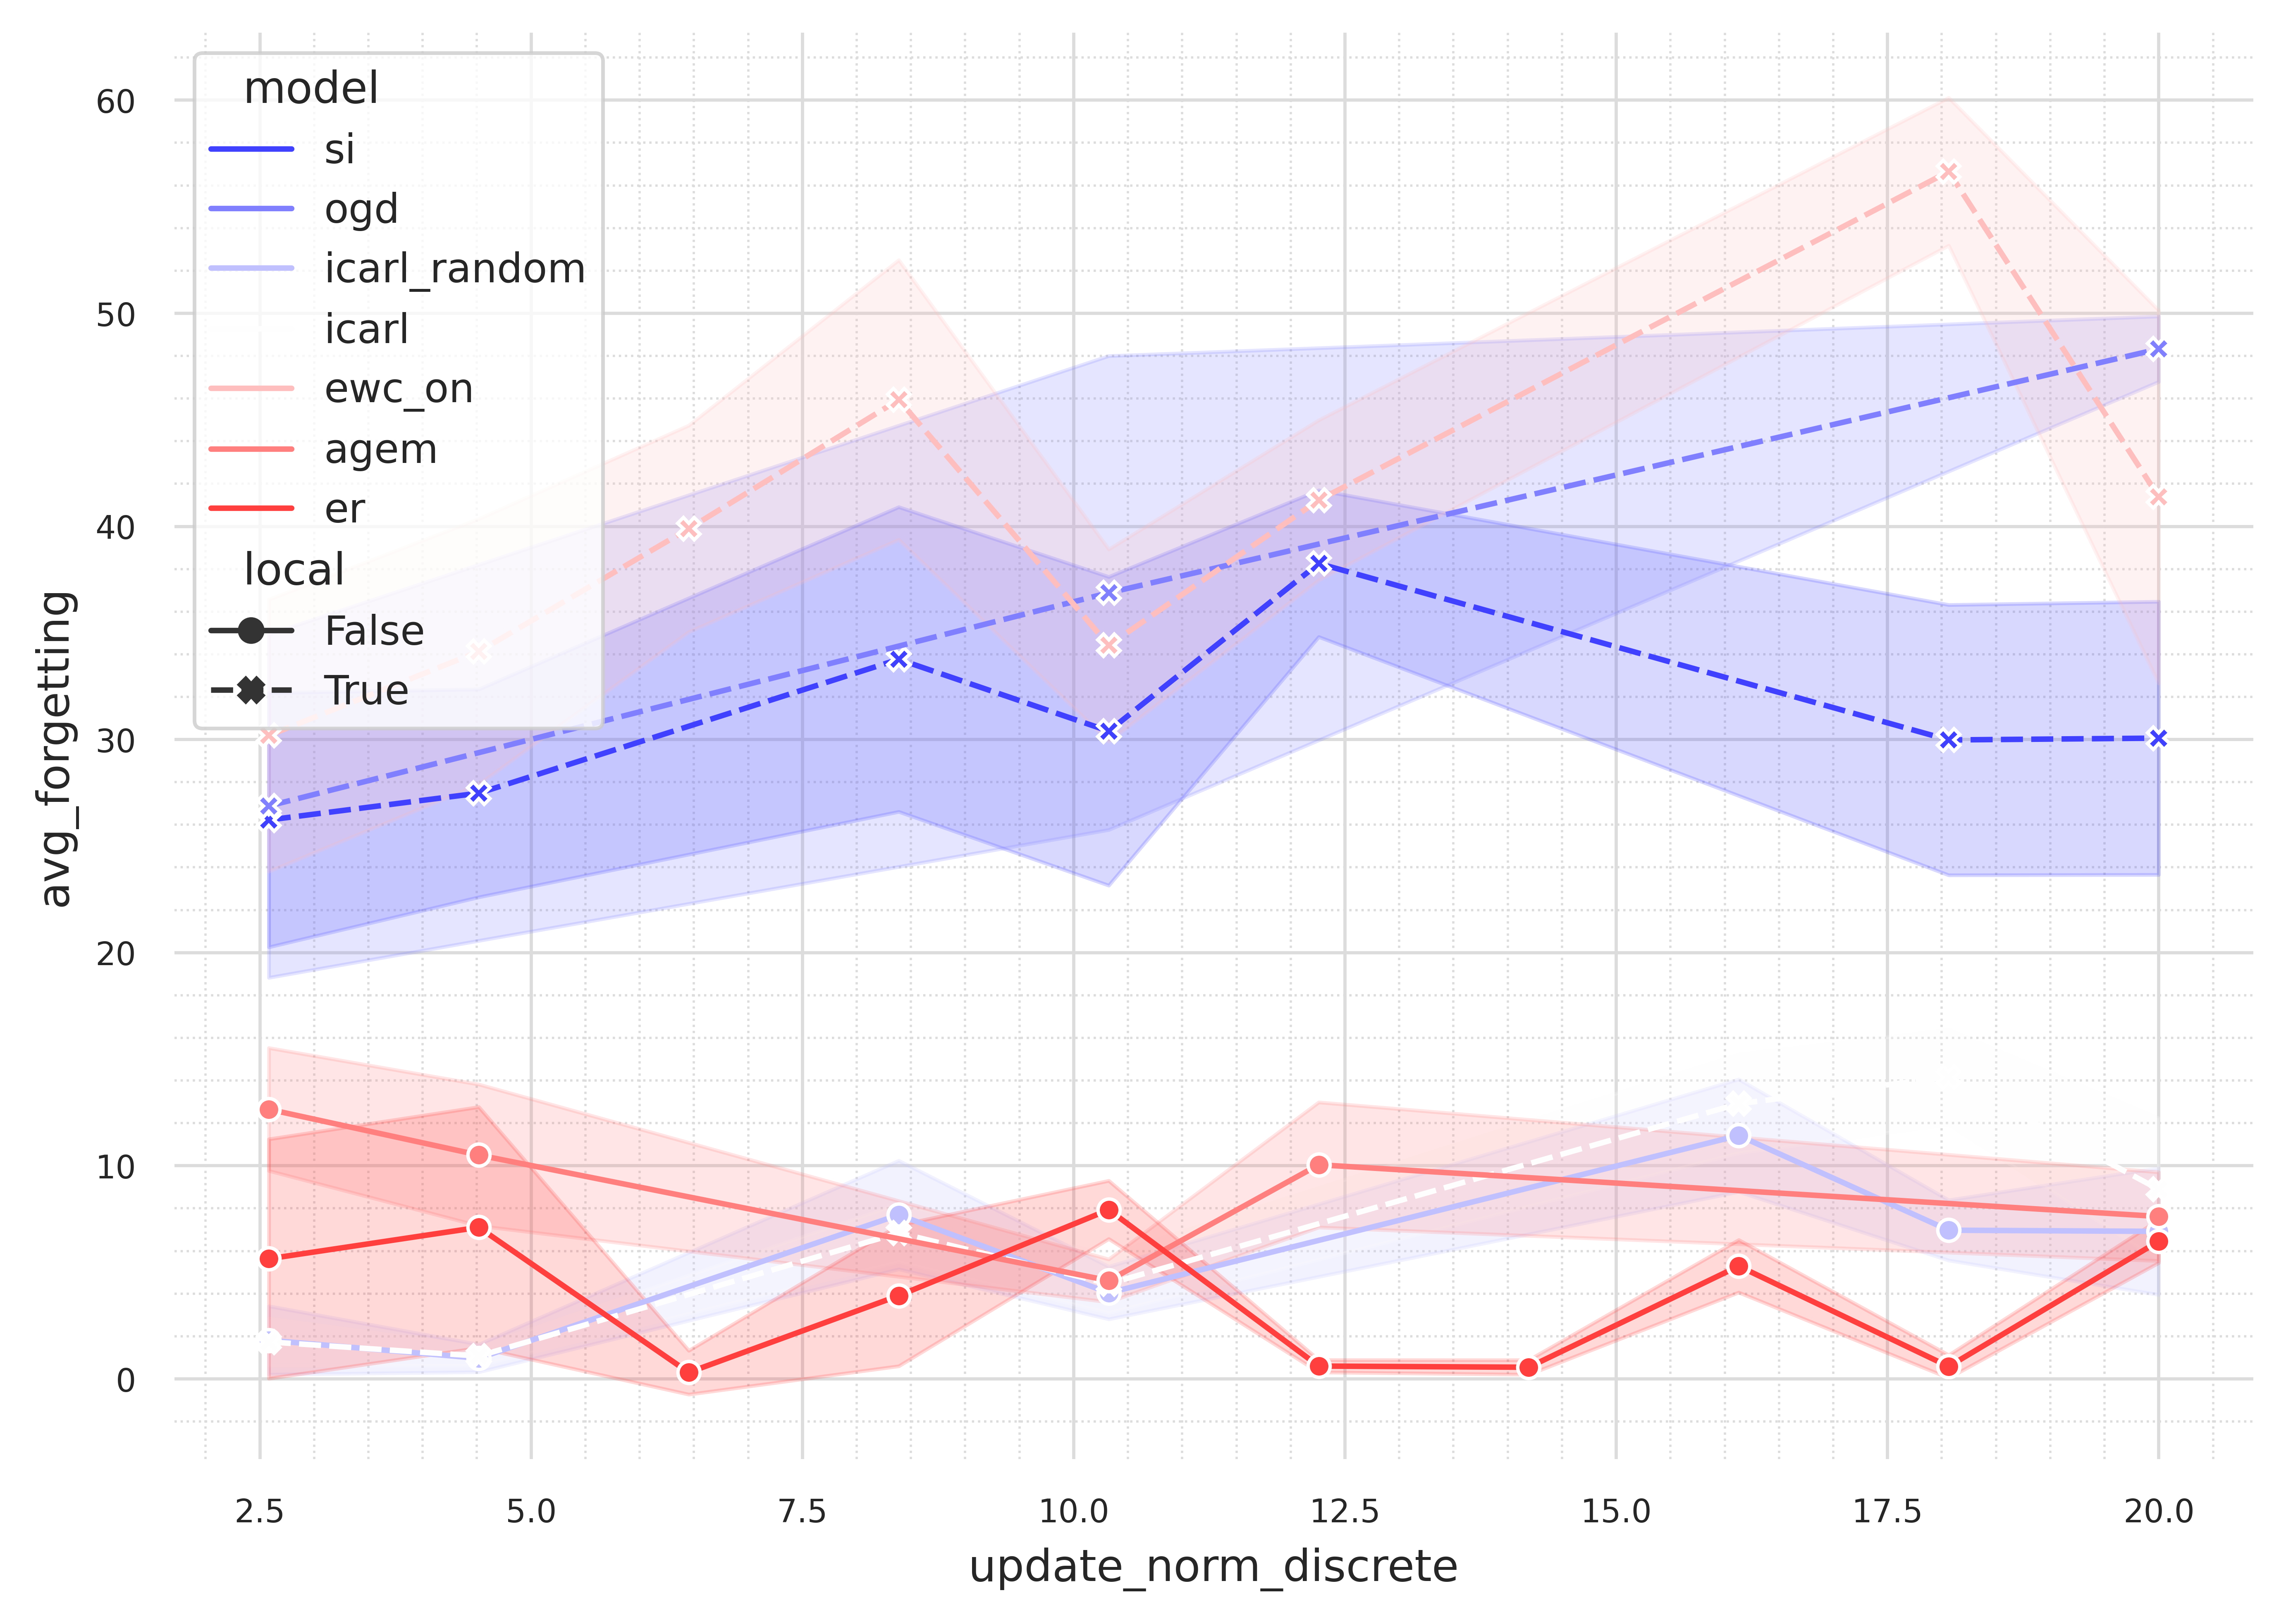

In [275]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,1, figsize=(7,5), sharey=False, dpi=800, constrained_layout=True)
    #colors = ['orange','royalblue','goldenrod','yellowgreen','lightseagreen']
    
    _df = all_c10_res_melted.loc[all_c10_res_melted['notes']!="testrun"] # excluding test runs
    _df = process_dataframe(_df)
    _df = _df.loc[_df['model']!='sgd']
    _df = _df.loc[_df['task']>1]
    _df = _df.loc[_df['update_norm']<=20]
    _df = discretize_column(_df, 'update_norm', bins=10)

    sns.lineplot(data=_df, x="update_norm_discrete", y="avg_forgetting", errorbar="sd", 
                 markers=True, marker='o', hue="model", style='local', palette='bwr', ls='-',ax=ax)
    
    #ax[2].set_xscale('log')
    #ax.set_title(f"CIFAR100", fontsize=10, y=1.)
    #ax.set_ylabel(r'Test error', fontsize=10)
    #ax.set_xlabel(r'$\kappa$', fontsize=10, y=+1)
    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    [ax.spines[side].set_color('whitesmoke') for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.tick_params('both', labelsize=7)

    #ax.set_xlim(0.0, 20)
    #ax.set_yticks(range(10,80,15))
    #ax.set_yticklabels(str(i) for i in range(10,80,15))

    
     # --------------------------------------------------------------------------
    # h, _ = ax.get_legend_handles_labels()
    # ax.get_legend().remove()


    # fig.legend([h[0],h[1],h[3],h[2],h[4]], [r'distillation ($\alpha=0.$)',
    #                r'$\alpha=0.25$',
    #                r'$\alpha=0.5$',
    #                r'$\alpha=0.75$',
    #                r'labels ($\alpha=1.$)'], ncols=1, 
    #            loc="center right") 

    
    #sns.despine()
    plt.tight_layout()


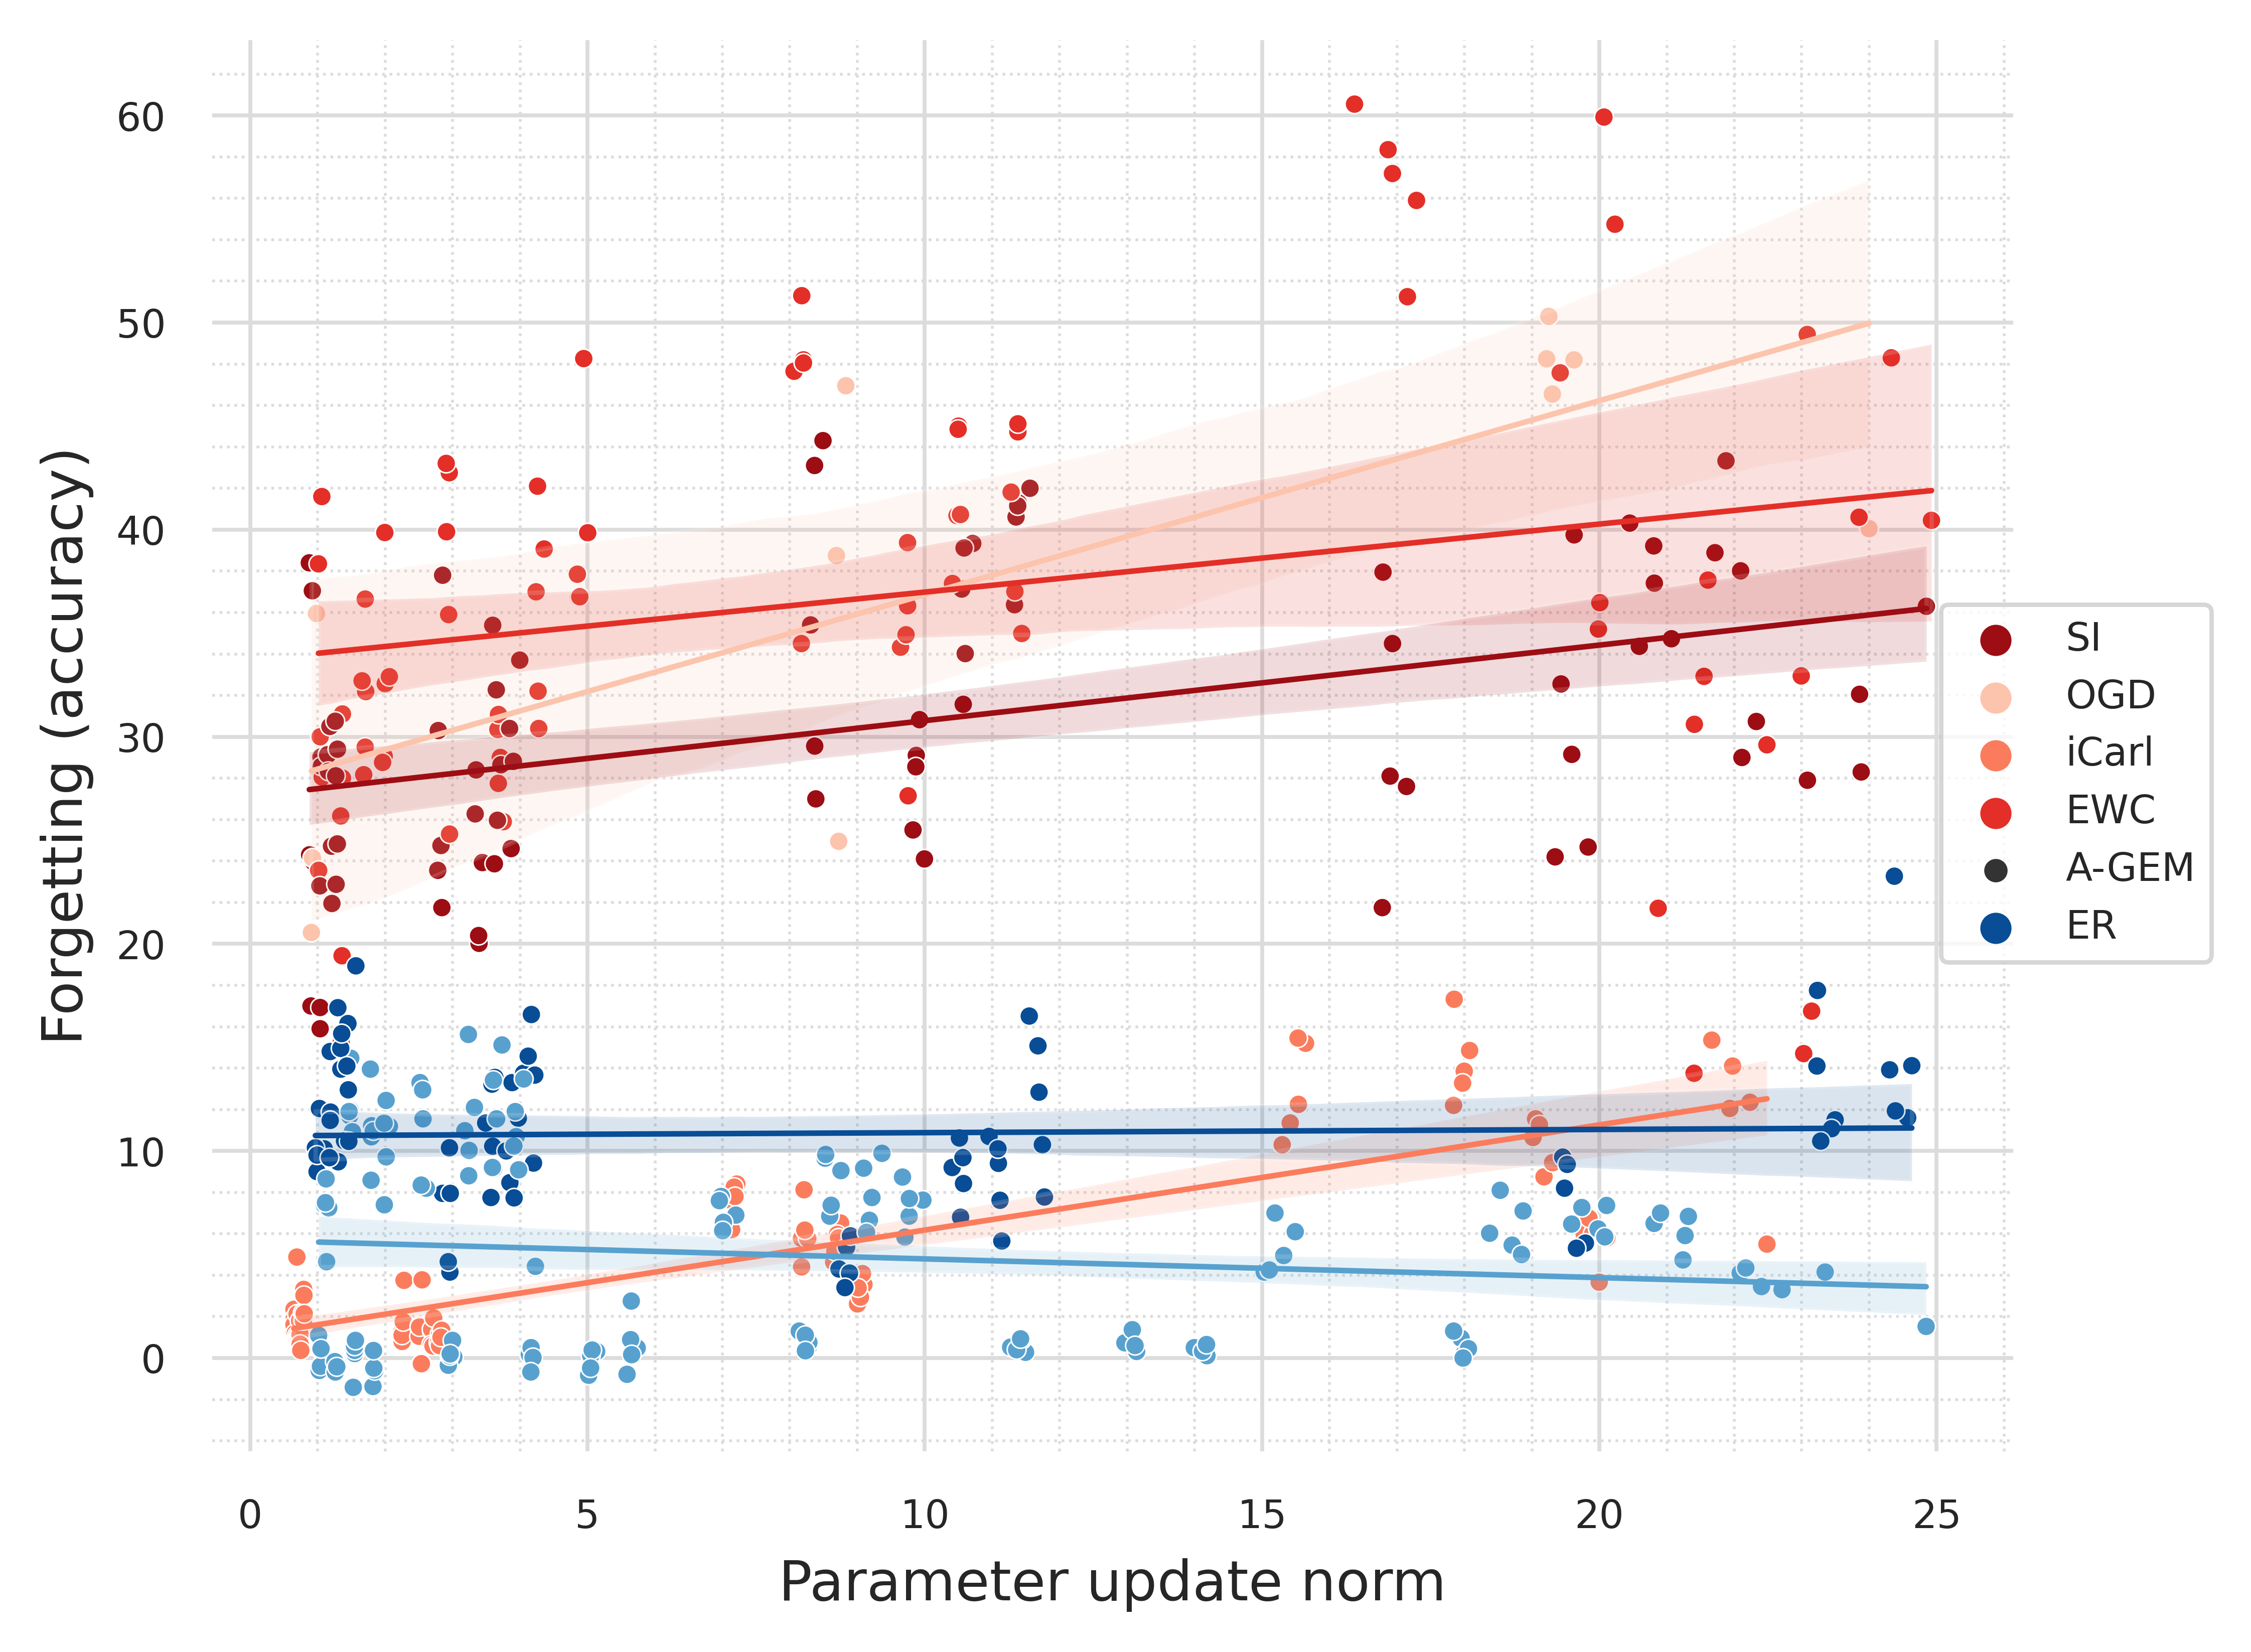

In [380]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,1, figsize=(5,4), sharey=False, dpi=800, constrained_layout=True)
    #colors = ['orange','royalblue','goldenrod','yellowgreen','lightseagreen']
    

    colors1=sns.color_palette('Blues', n_colors=8); 
    colors2=sns.color_palette('Reds', n_colors=8); 

    my_palette={'ogd':colors2[1], 
                'icarl':colors2[3],
                'ewc_on':colors2[5],
                'si':colors2[7],
                'er':colors1[4],
                'agem':colors1[7]}


    _df = all_c10_res_melted.loc[all_c10_res_melted['notes']!="testrun"] # excluding test runs
    _df = process_dataframe(_df)
    _df = _df.loc[_df['task']>1]
    _df = _df.loc[_df['update_norm']<=25]
    _df = discretize_column(_df, 'update_norm', bins=10)



    _dfl = _df.loc[_df['model'].isin(['ogd','icarl','ewc_on','si'])]
    sns.scatterplot(data=_dfl, x="update_norm", y="avg_forgetting", size=1,
                 markers=True, marker='o', hue="model", palette=my_palette, ls='-',ax=ax)
    

    _dfg = _df.loc[_df['model'].isin(['er','agem'])]
    sns.scatterplot(data=_dfg, x="update_norm", y="avg_forgetting", size=1,
                 markers=True, marker='o', hue="model", palette=my_palette, ls='-',ax=ax)
    
    for m in my_palette.keys():
        _dfr = _df.loc[_df['model']==m] # excluding test runs
        sns.regplot(data=_dfr, x="update_norm", y="avg_forgetting", ax=ax,  scatter=False,
                     label=m, color=my_palette[m], line_kws={'lw':1})
    
    
    ax.set_ylabel(r'Forgetting (accuracy)', fontsize=10)
    ax.set_xlabel(r'Parameter update norm', fontsize=10)
    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    [ax.spines[side].set_color('whitesmoke') for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.tick_params('both', labelsize=7)

    #ax.set_xlim(0.0, 20)
    #ax.set_yticks(range(10,80,15))
    #ax.set_yticklabels(str(i) for i in range(10,80,15))

    
     # --------------------------------------------------------------------------
    h, l = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    l = ['SI','OGD','iCarl', 'EWC', 'A-GEM', 'ER']
    lgd = fig.legend(h[:6], l, ncols=1, bbox_to_anchor=(1.1, 0.65), fontsize=7) 
    

    
    fig.savefig('Forgetting.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')


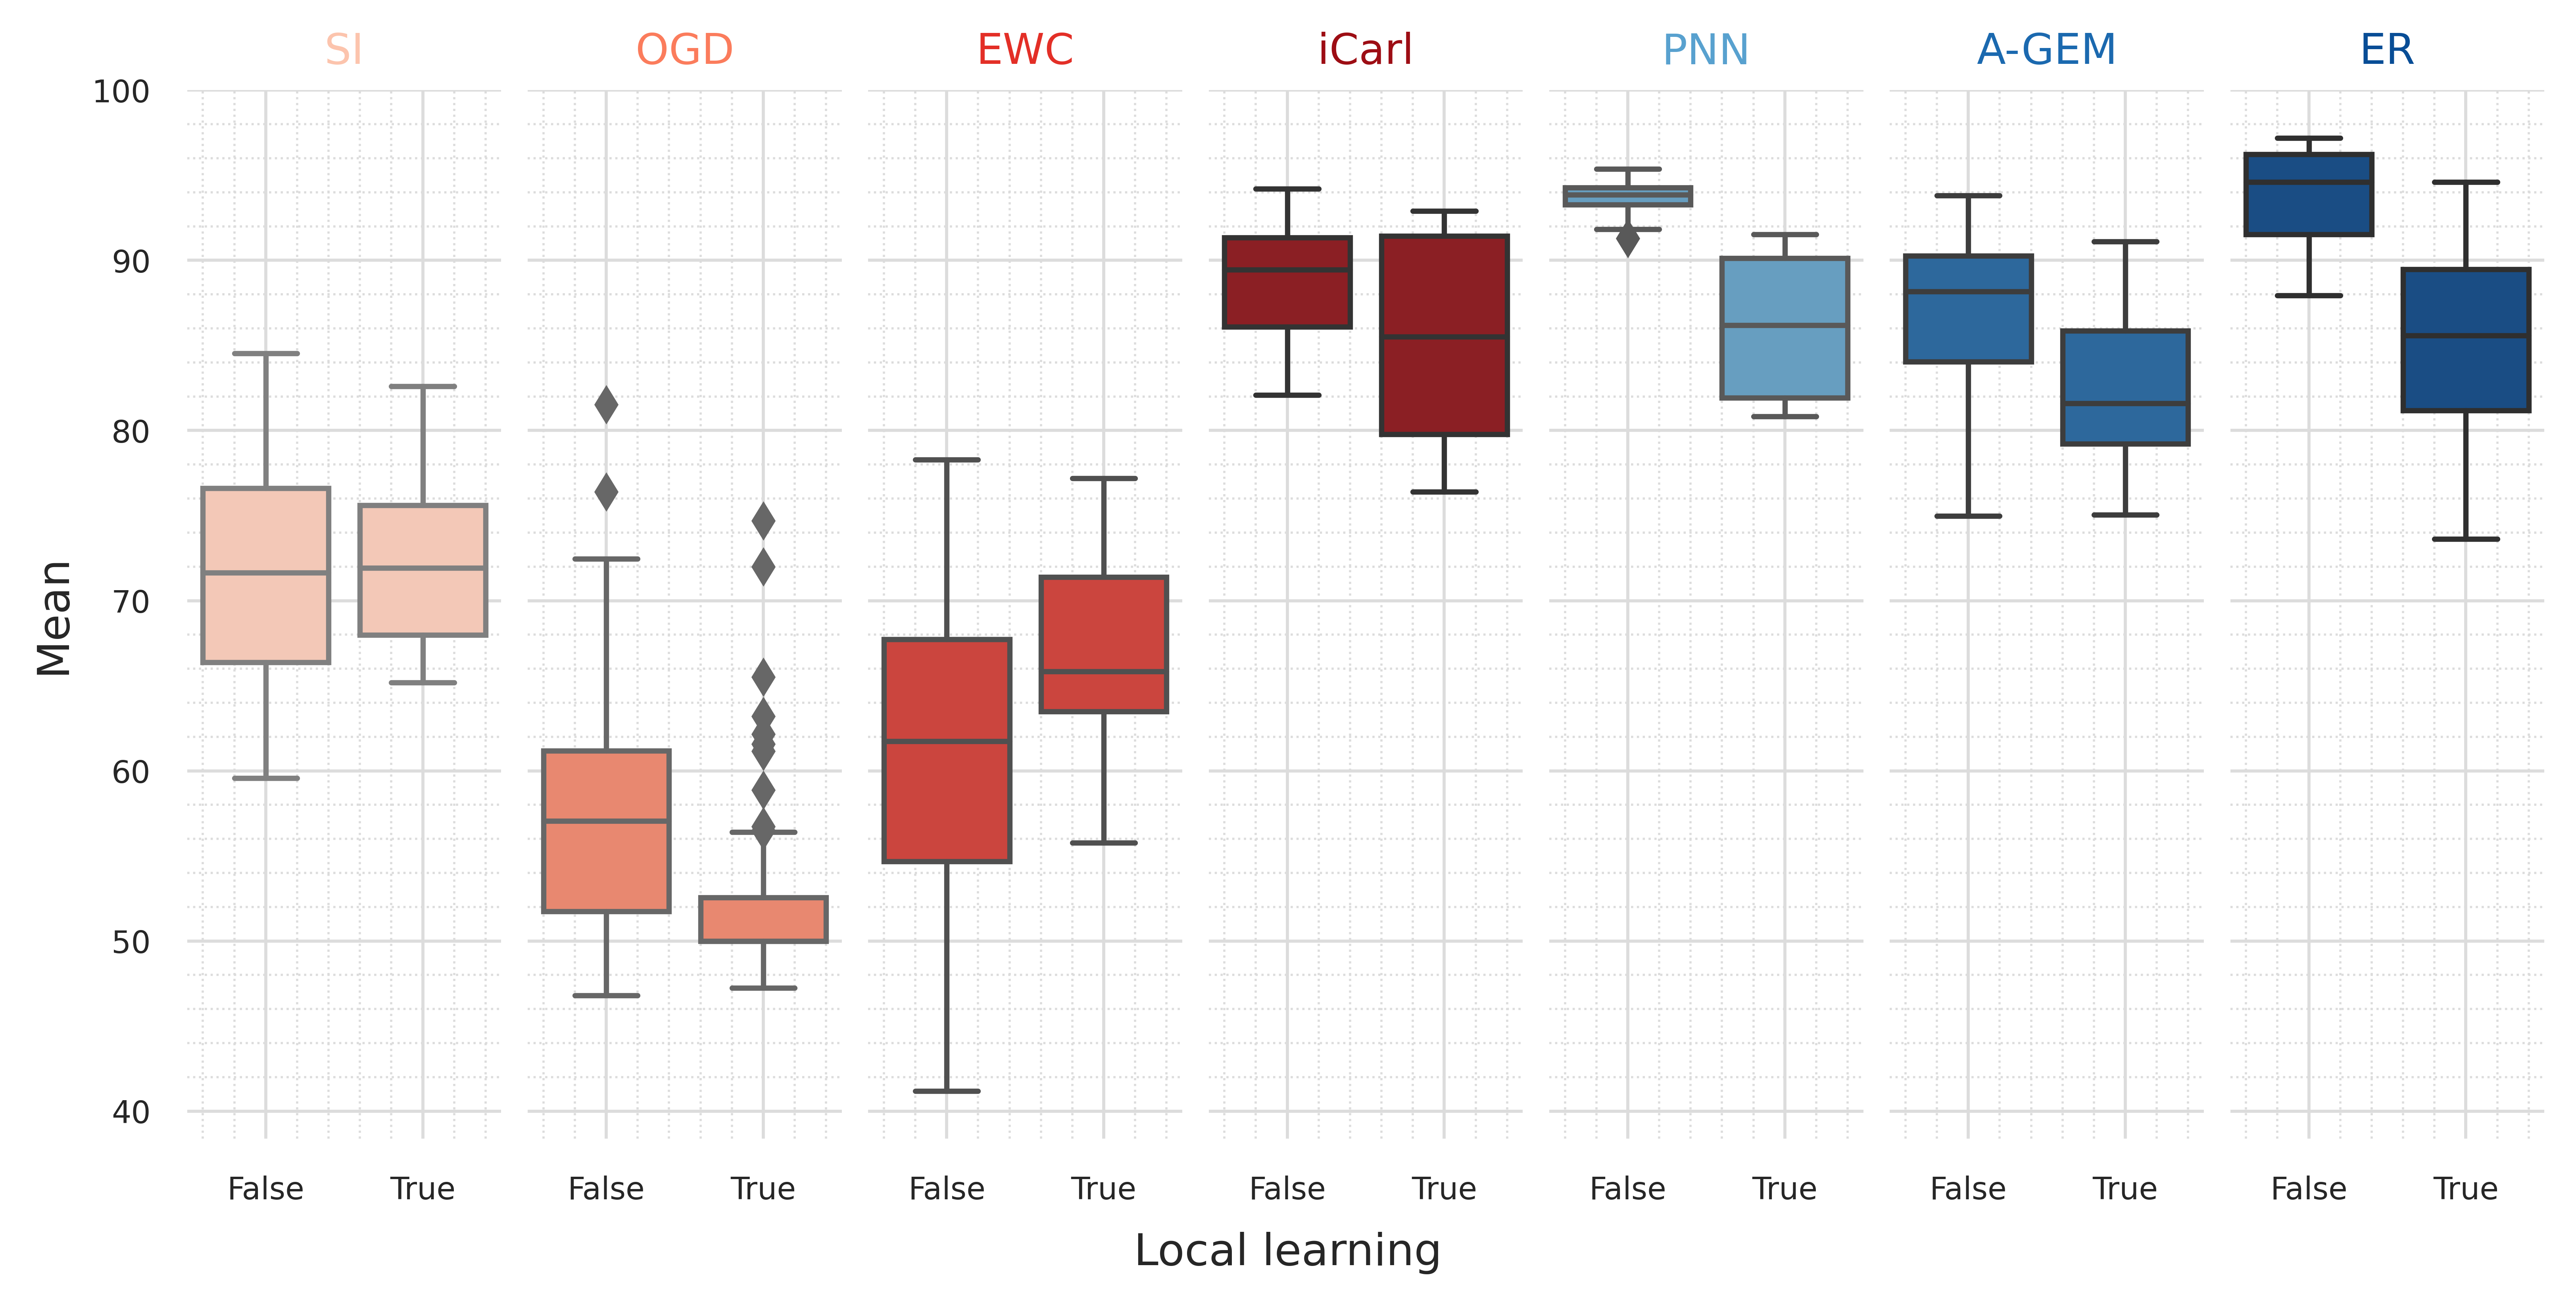

In [416]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,7, figsize=(8,4), sharey=True, sharex=True, dpi=800, constrained_layout=True)
    #colors = ['orange','royalblue','goldenrod','yellowgreen','lightseagreen']
    


    colors1=sns.color_palette('Blues', n_colors=8); 
    colors2=sns.color_palette('Reds', n_colors=8); 

    l = ['SI','OGD','EWC', 'iCarl', 'PNN','A-GEM', 'ER']

    my_palette={'si':colors2[1],
                'ogd':colors2[3], 
                'ewc_on':colors2[5],
                'icarl':colors2[7],
                'pnn':colors1[4],
                'agem':colors1[6],
                'er':colors1[7],}


    _df = all_c10_res_melted.loc[all_c10_res_melted['notes']!="testrun"] # excluding test runs
    _df = process_dataframe(_df)
    _df = _df.loc[_df['task']>1]
    _df['low_lr'] = _df['lr'] <= 0.001
    #_df = _df.loc[_df['update_norm']<=25]
    _df = discretize_column(_df, 'update_norm', bins=10)

    for i,m in enumerate(my_palette.keys()):
        _dfr = _df.loc[_df['model']==m] # excluding test runs
        sns.boxplot(data=_dfr, x='low_lr', y="avg_forgetting", ax=ax[i],  color=my_palette[m])
    
        _ax = ax[i]
        _ax.set_title(l[i], color=my_palette[m])
        _ax.set_ylabel(r'', fontsize=10)
        _ax.set_xlabel(r'', fontsize=10)
        # AESTHETICS control 
        _ax.set_facecolor('white')
        [_ax.spines[side].set_visible(False) for side in _ax.spines]
        [_ax.spines[side].set_color('whitesmoke') for side in _ax.spines]
        # major and minor grids
        _ax.grid(which='major', color='gainsboro', linewidth=0.7)
        _ax.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
        # Make the minor ticks and gridlines show.
        _ax.minorticks_on()
        _ax.tick_params('both', labelsize=7)

    ax[0].set_ylabel(r'Mean accuracy', fontsize=10)
    fig.supxlabel(r'Local learning', fontsize=10)

    #ax.set_xlim(0.0, 20)
    #ax.set_yticks(range(10,80,15))
    #ax.set_yticklabels(str(i) for i in range(10,80,15))

    
     # --------------------------------------------------------------------------
    # h, l = ax.get_legend_handles_labels()
    # ax.get_legend().remove()

    

    
    fig.savefig('Boxplot2.pdf',bbox_inches='tight')


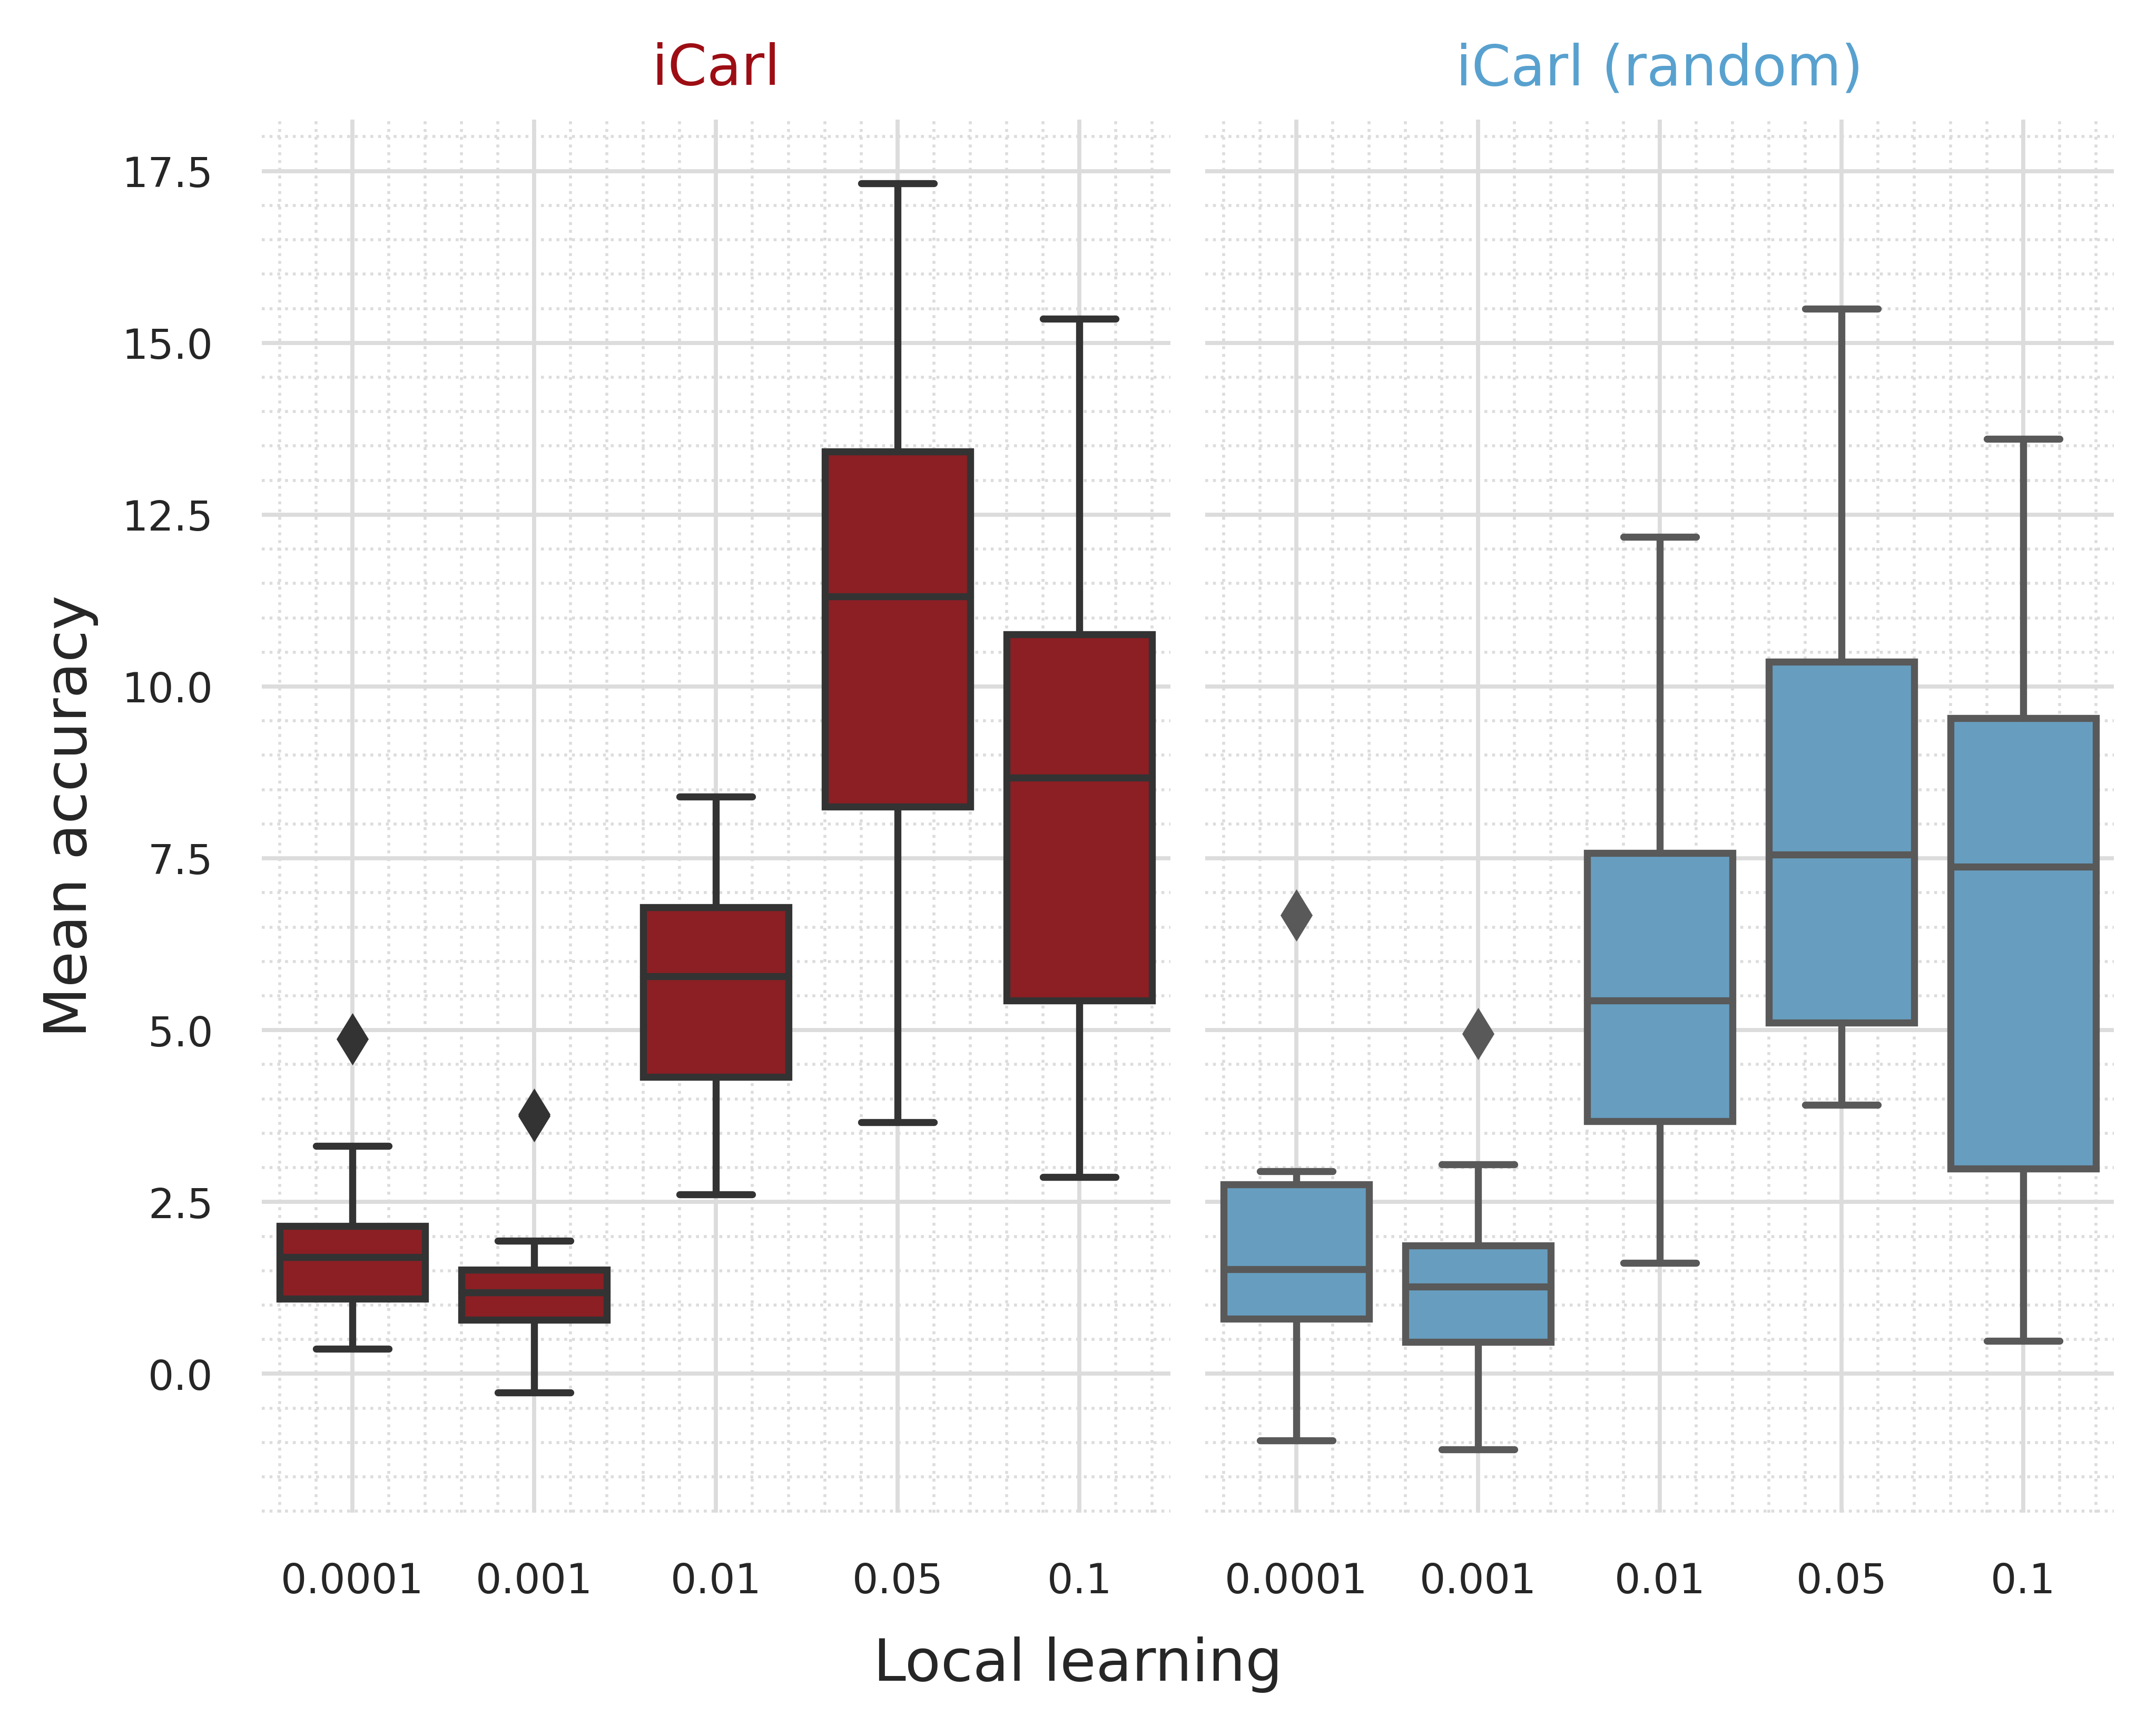

In [413]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,2, figsize=(5,4), sharey=True, sharex=True, dpi=800, constrained_layout=True)
    #colors = ['orange','royalblue','goldenrod','yellowgreen','lightseagreen']
    


    colors1=sns.color_palette('Blues', n_colors=8); 
    colors2=sns.color_palette('Reds', n_colors=8); 

    l = ['iCarl', 'iCarl (random)']

    my_palette={
                'icarl':colors2[7],
                'icarl_random':colors1[4]
                }


    _df = all_c10_res_melted.loc[all_c10_res_melted['notes']!="testrun"] # excluding test runs
    _df = process_dataframe(_df)
    _df = _df.loc[_df['task']>1]
    _df['low_lr'] = _df['lr'] <= 0.001
    #_df = _df.loc[_df['update_norm']<=25]
    _df = discretize_column(_df, 'update_norm', bins=10)

    for i,m in enumerate(my_palette.keys()):
        _dfr = _df.loc[_df['model']==m] # excluding test runs
        sns.boxplot(data=_dfr, x='lr', y="avg_forgetting", ax=ax[i],  color=my_palette[m])
    
        _ax = ax[i]
        _ax.set_title(l[i], color=my_palette[m])
        _ax.set_ylabel(r'', fontsize=10)
        _ax.set_xlabel(r'', fontsize=10)
        # AESTHETICS control 
        _ax.set_facecolor('white')
        [_ax.spines[side].set_visible(False) for side in _ax.spines]
        [_ax.spines[side].set_color('whitesmoke') for side in _ax.spines]
        # major and minor grids
        _ax.grid(which='major', color='gainsboro', linewidth=0.7)
        _ax.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
        # Make the minor ticks and gridlines show.
        _ax.minorticks_on()
        _ax.tick_params('both', labelsize=7)

    ax[0].set_ylabel(r'Mean accuracy', fontsize=10)
    fig.supxlabel(r'Local learning', fontsize=10)

    #ax.set_xlim(0.0, 20)
    #ax.set_yticks(range(10,80,15))
    #ax.set_yticklabels(str(i) for i in range(10,80,15))

    
     # --------------------------------------------------------------------------
    # h, l = ax.get_legend_handles_labels()
    # ax.get_legend().remove()

    

    
    fig.savefig('icarl.pdf',bbox_inches='tight')


/tmp/ipykernel_2663775/1806714630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lr_cat']= df['lr'].astype('category')
/tmp/ipykernel_2663775/1416250299.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


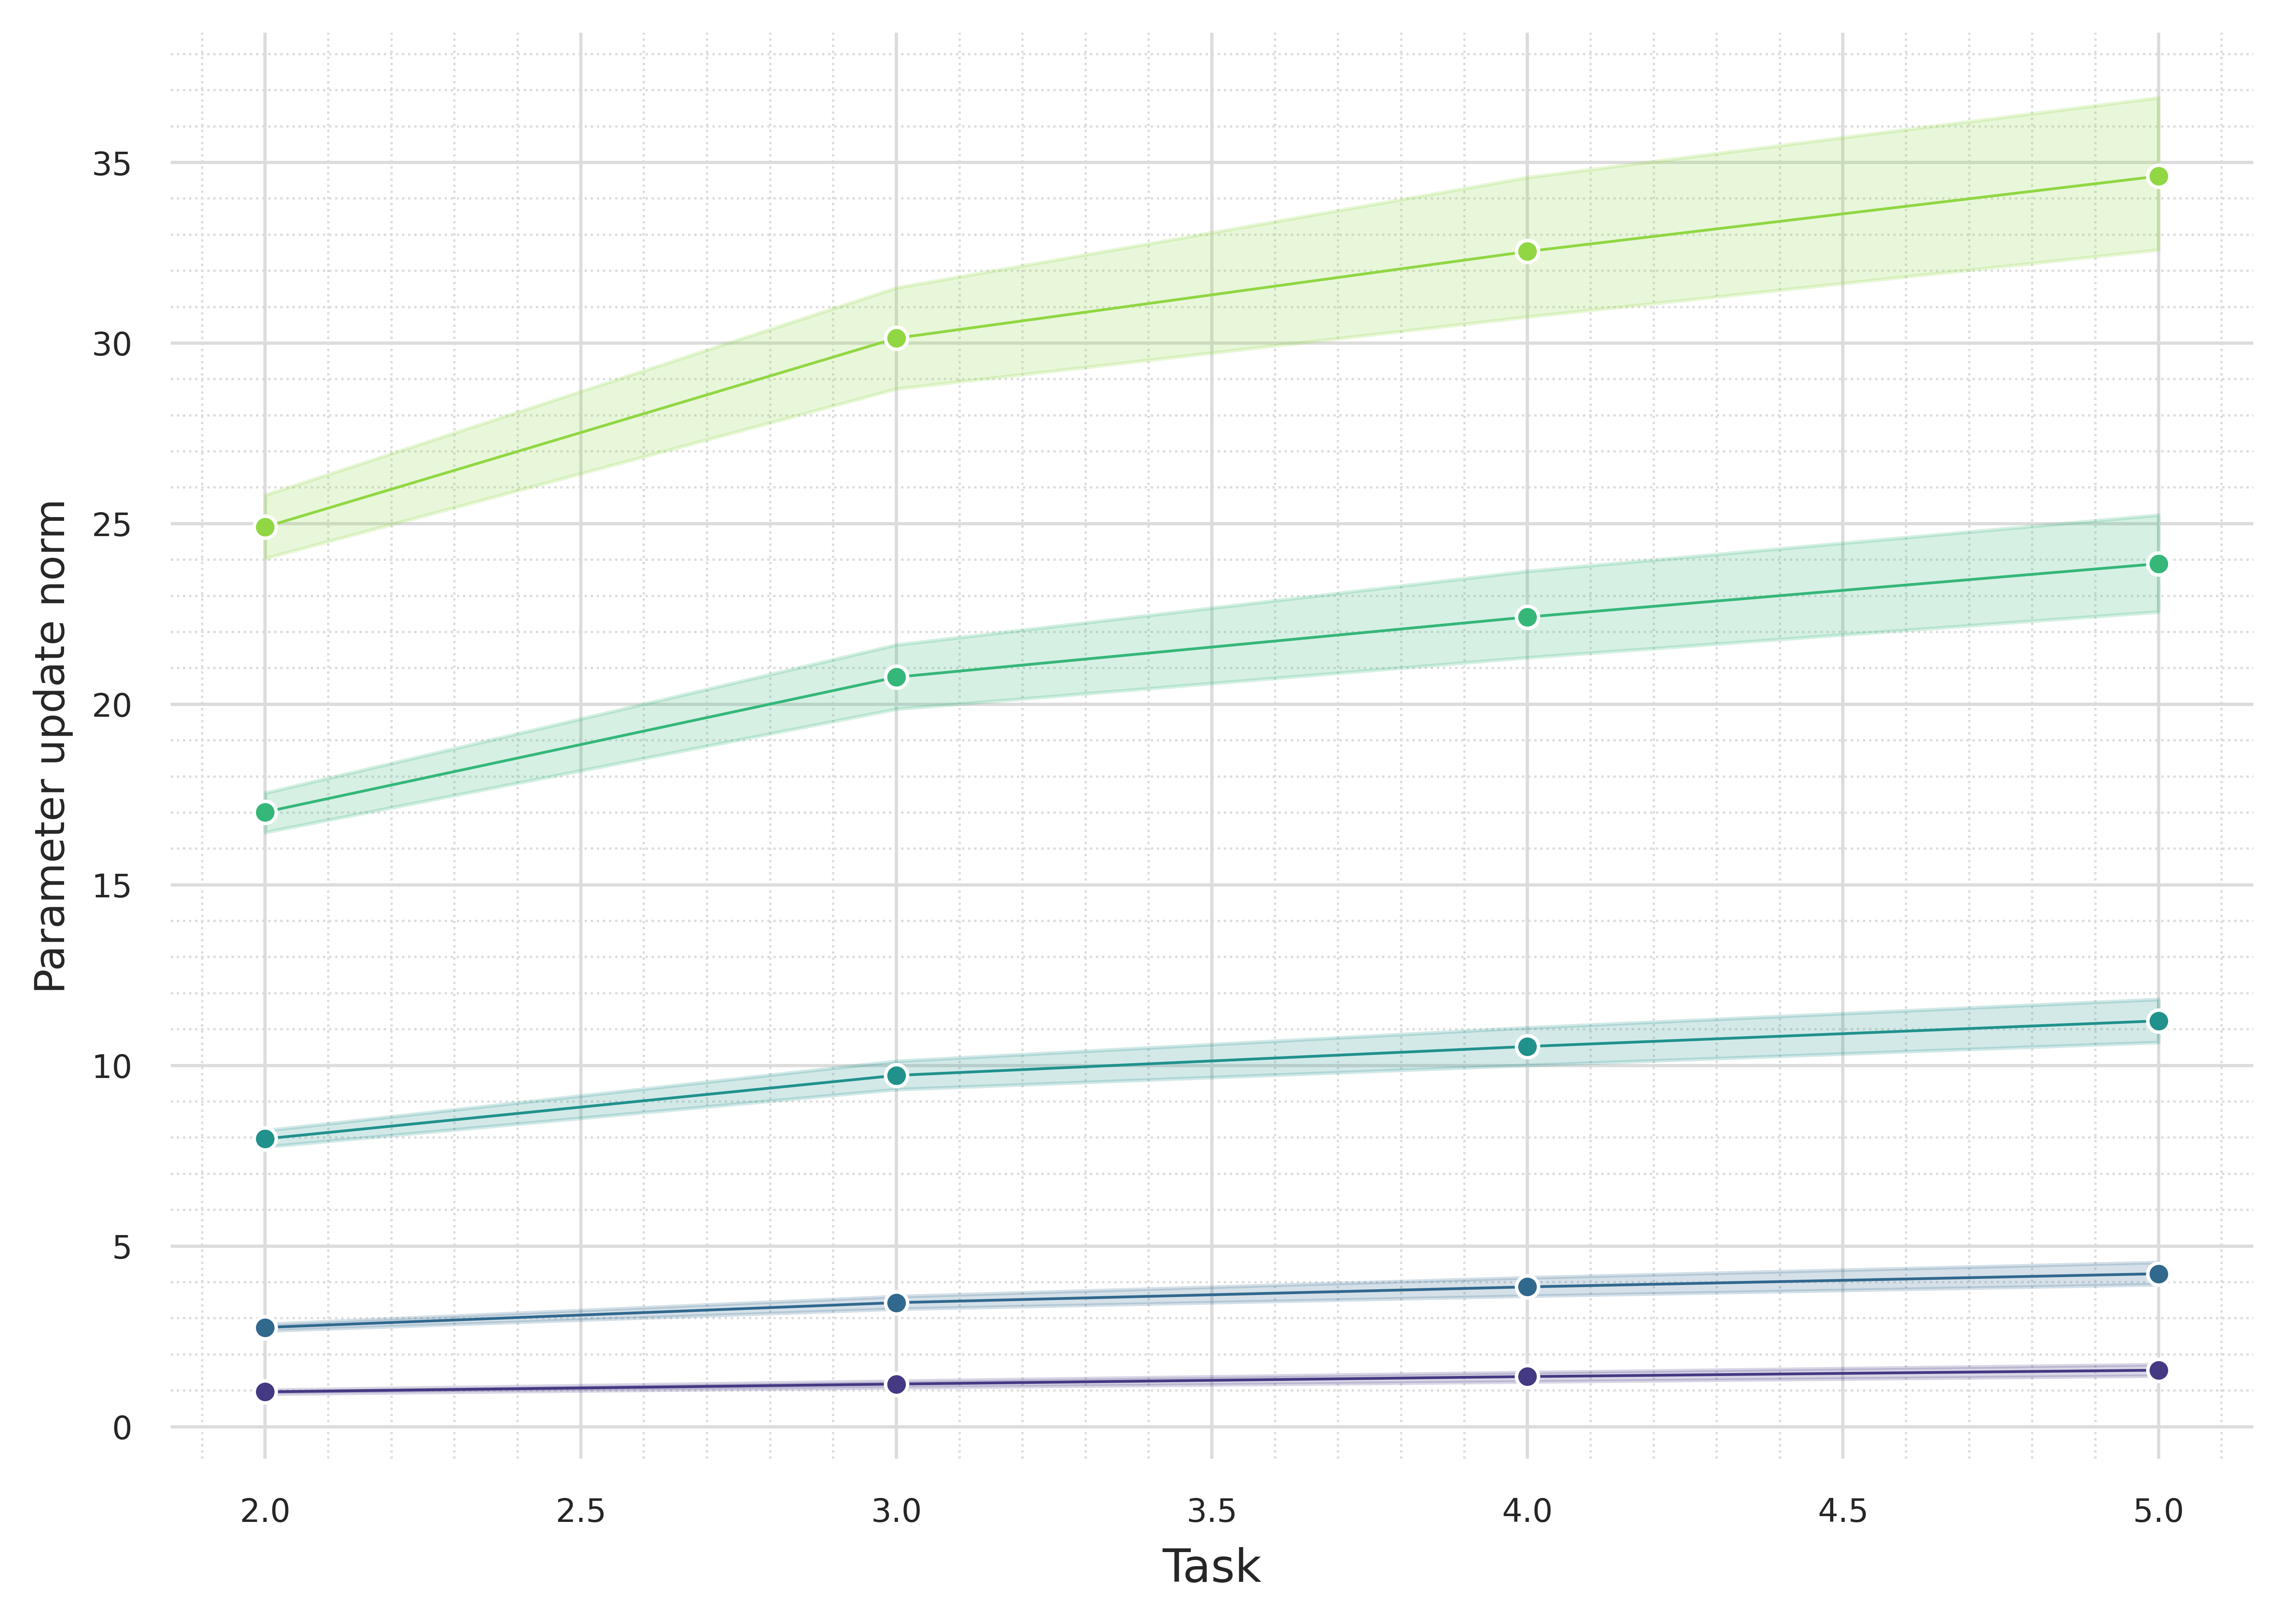

In [428]:
%matplotlib inline
sns.set_context("paper")
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(1,1, figsize=(7,5), sharey=False, dpi=800, constrained_layout=True)
    #colors = ['orange','royalblue','goldenrod','yellowgreen','lightseagreen']
    


    colors1=sns.color_palette('Blues', n_colors=8); 
    colors2=sns.color_palette('Reds', n_colors=8); 

    my_palette={'ogd':colors2[1], 
                'icarl':colors2[3],
                'ewc_on':colors2[5],
                'si':colors2[7],
                'er':colors1[4],
                'agem':colors1[7]}



    _df = all_c10_res_melted.loc[all_c10_res_melted['notes']!="testrun"] # excluding test runs
    _df = process_dataframe(_df)
    _df = _df.loc[_df['task']>1]
    _df = _df.loc[_df['update_norm']<=100]
    _df = discretize_column(_df, 'update_norm', bins=10)
    _df = _df.loc[_df['model'].isin(['icarl','ewc_on','si','er','agem'])]


    #_dfl = _df.loc[_df['model'].isin(['ogd','icarl','ewc_on','si'])]
    sns.lineplot(data=_df, x="task", y="update_norm", size=1,
                 markers=True, marker='o', hue="lr_cat",  palette="viridis",
                   ls='-',ax=ax)
    
    
    #ax.set_title(f"CIFAR100", fontsize=10, y=1.)
    ax.set_ylabel(r'Parameter update norm', fontsize=9)
    ax.set_xlabel(r'Task', fontsize=10, y=+1)
    # AESTHETICS control 
    ax.set_facecolor('white')
    [ax.spines[side].set_visible(False) for side in ax.spines]
    [ax.spines[side].set_color('whitesmoke') for side in ax.spines]
    # major and minor grids
    ax.grid(which='major', color='gainsboro', linewidth=0.7)
    ax.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
    # Make the minor ticks and gridlines show.
    ax.minorticks_on()
    ax.tick_params('both', labelsize=7)

    #ax.set_xlim(0.0, 20)
    #ax.set_yticks(range(10,80,15))
    #ax.set_yticklabels(str(i) for i in range(10,80,15))

    
     # --------------------------------------------------------------------------
    h, _ = ax.get_legend_handles_labels()
    ax.get_legend().remove()


    
    #sns.despine()
    plt.tight_layout()
